In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [19]:
ETH = yf.download('ETH-USD', start='2023-04-14', end='2023-04-15',  interval = '1m')

[*********************100%***********************]  1 of 1 completed


In [20]:
BTC = yf.download('BTC-USD', start='2023-04-14', end='2023-04-15',  interval = '1m')

[*********************100%***********************]  1 of 1 completed


In [21]:
# Setting the initial value of S1_0 and S2_0 by the open price of ETH and BTC on 14 Apr
S1_0 = ETH['Open'][0]
S2_0 = BTC['Open'][0]
print(S1_0, '\n',S2_0)

2013.9306640625 
 30409.5625


In [ ]:
# Since this model using stimulation for S1 and S2, hence any date data can be used to calibrate coefficient factors.
# Here, use the same date of 14 Apr.

lr1 = np.log(ETH['Adj Close'] / ETH['Adj Close'].shift(1))
lr2 = np.log(BTC['Adj Close'] / BTC['Adj Close'].shift(1))
mu_1 = lr1.mean() * 1440
mu_2 = lr2.mean() * 1440
sigma_1 = lr1.std() * np.sqrt(1440)
sigma_2 = lr2.std() * np.sqrt(1440)
rho = lr1.corr(lr2)
z_0 = 0.00
gamma = 0.5
delta = 0.8
T = 1
M = len(BTC)

In [23]:
result = linregress(np.log(ETH['Adj Close']), np.log(BTC['Adj Close']))
beta = result.slope

In [24]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

### Stimulate co-integrated factor, value of S1 and S2

In [25]:
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

Text(0.5, 1.0, 'ETH and BTC stimulating price movement')

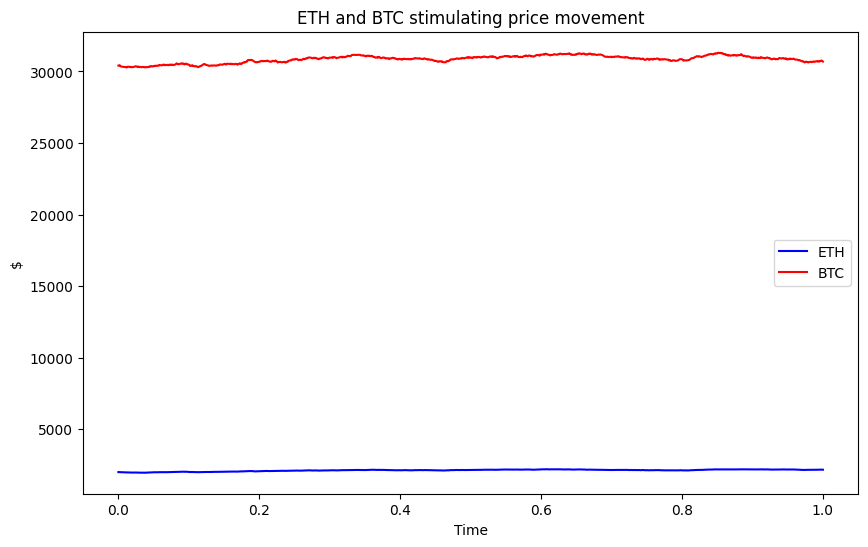

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='ETH')
plt.plot(tt, S2, 'r', lw=1.5, label='BTC')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('ETH and BTC stimulating price movement')

Text(0.5, 1.0, 'z')

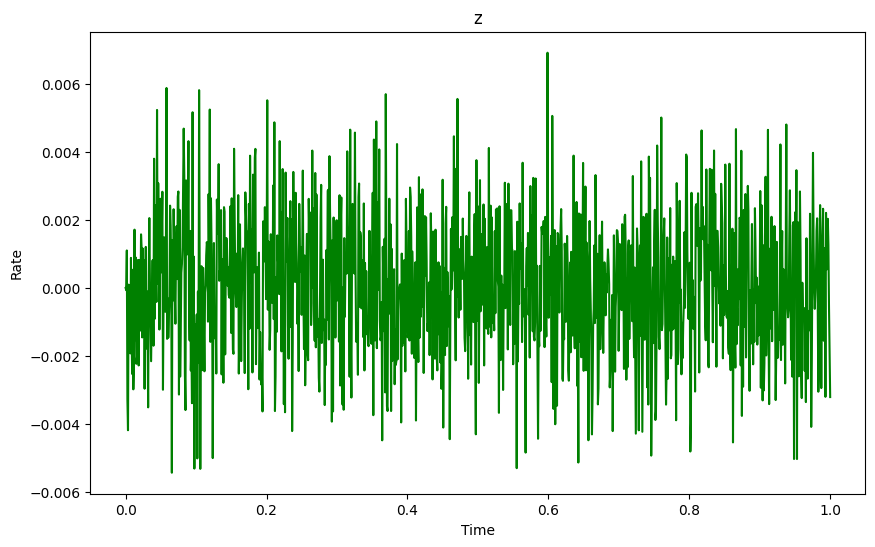

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('z')

### Optimal Trading Weights

In [28]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))


Text(0.5, 1.0, 'Weights')

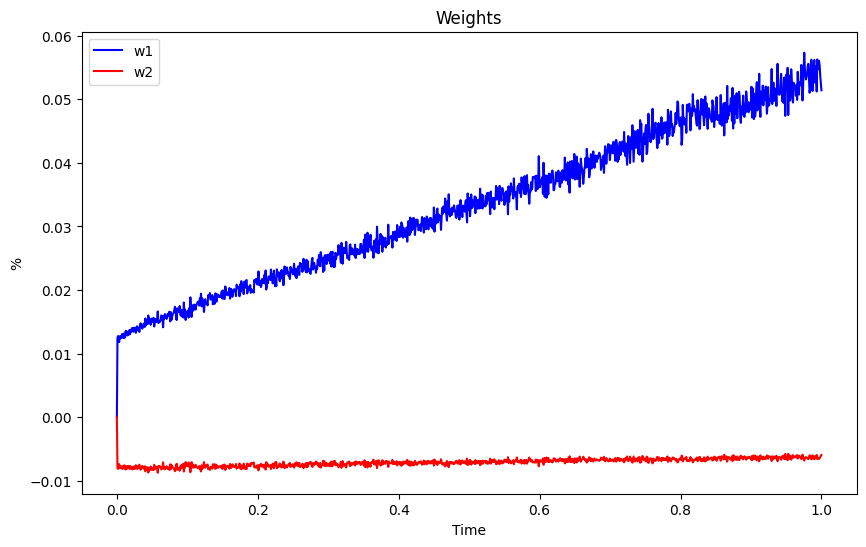

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

### Optimal Wealths

Text(0.5, 1.0, 'Wealth')

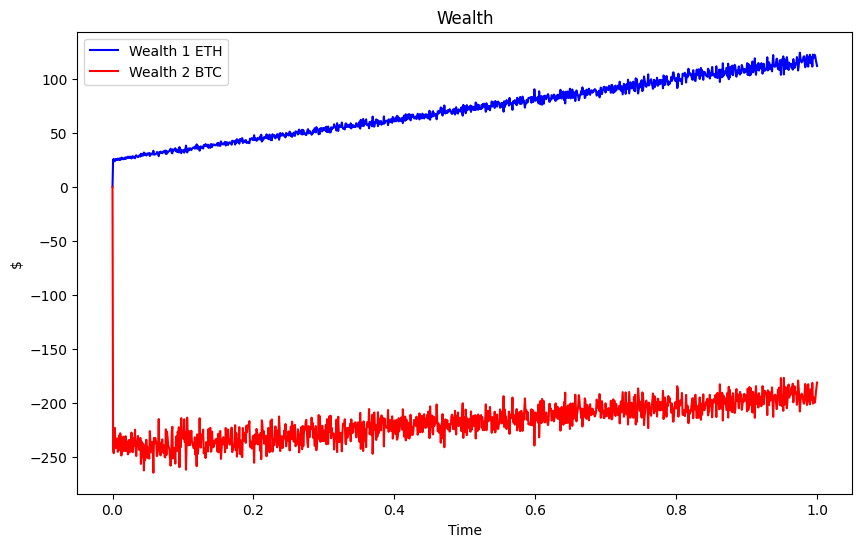

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Wealth 1 ETH')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Wealth 2 BTC')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Wealth')

### Total wealth

In [31]:
Wealth = abs(Pi_1 * S1) + abs(Pi_2 * S2)

Text(0.5, 1.0, 'Total Wealth')

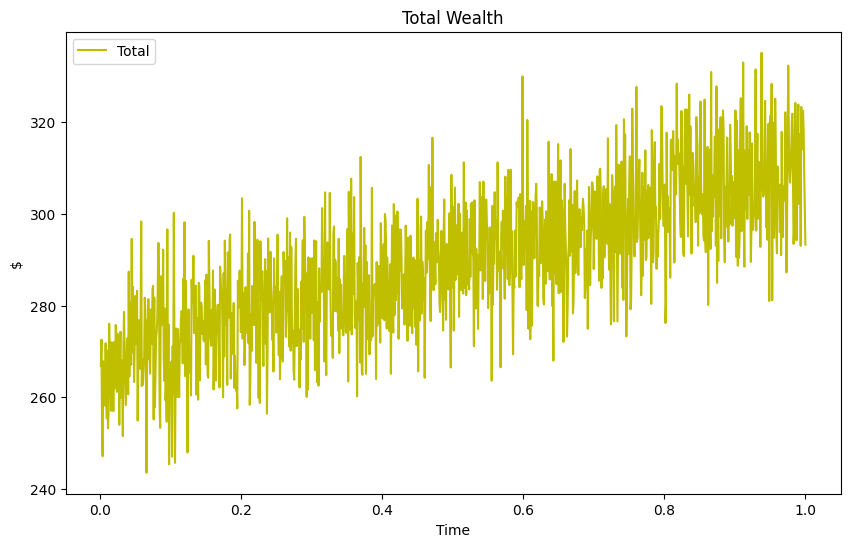

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], Wealth[1:], 'y', lw=1.5, label='Total')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Total Wealth')

In [33]:
Wealth[1]
Wealth[-1]
Return = (Wealth[-1] - Wealth[1])/Wealth[1]  # Return
Return.item()
print('Initial Wealth', Wealth[1], '\n'
     'Final Wealth', Wealth[-1], '\n'
     'Return', Return.item())

Initial Wealth [266.8914182] 
Final Wealth [293.29347934] 
Return 0.09892435401006626


### Comparision with static control pair

Pi_1 mean 0.03324635465725407 
Pi_2 mean -0.007048541692875545


Text(0.5, 1.0, 'Comparison')

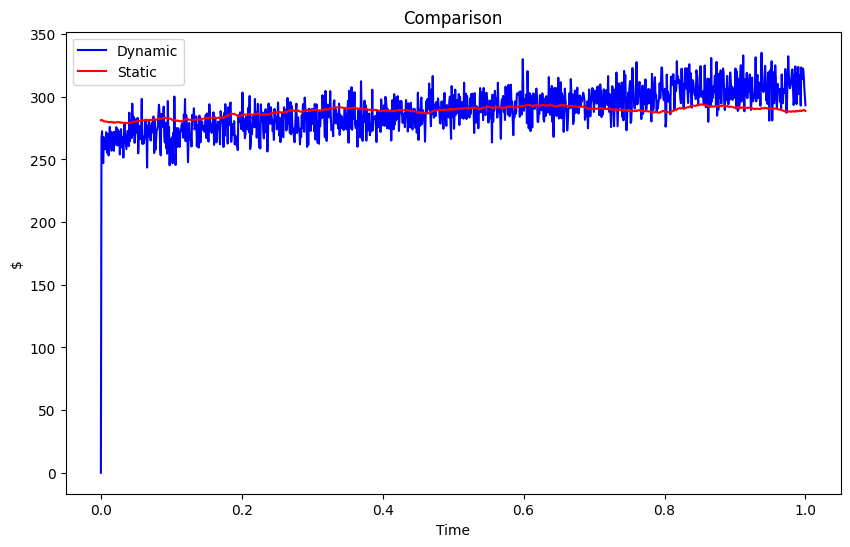

In [34]:
Pi_1.mean()
Pi_2.mean()
print('Pi_1 mean', Pi_1.mean(), '\n'
        'Pi_2 mean', Pi_2.mean())

plt.figure(figsize=(10, 6))
plt.plot(tt, abs(Pi_1 * S1) + abs(Pi_2 * S2), 'b', lw=1.5, label='Dynamic')
plt.plot(tt,  abs(Pi_1.mean() * S1) + abs(Pi_2.mean() * S2), 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')